# Load packages

In [1]:
import os.path
import pickle

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.metrics import confusion_matrix

In [15]:
# files = ["article_net", "cnn_lstm_complex", "cnn_lstm_simple", "stacked_bidirectional_lstm"]
files = ["cnn_lstm_simple"]

def get_metrics(files):
    results = []
    for file in files:
        res = pd.read_csv(os.path.join(file, "results.csv"), index_col=0)
        res["model"] = file
        results.append(res)
    return  pd.concat(results).reset_index(drop=True)

merged_data = get_metrics(files)
merged_data

,seed,loss,sparse_categorical_accuracy,sparse_categorical_crossentropy,model
0,0,0.202165,0.942107,0.202165,cnn_lstm_simple
1,1,0.202767,0.942644,0.202767,cnn_lstm_simple
2,2,0.184794,0.945025,0.184794,cnn_lstm_simple
3,3,0.287714,0.915464,0.287714,cnn_lstm_simple
4,4,0.185222,0.946560,0.185222,cnn_lstm_simple


# Basic models

## Boxplots

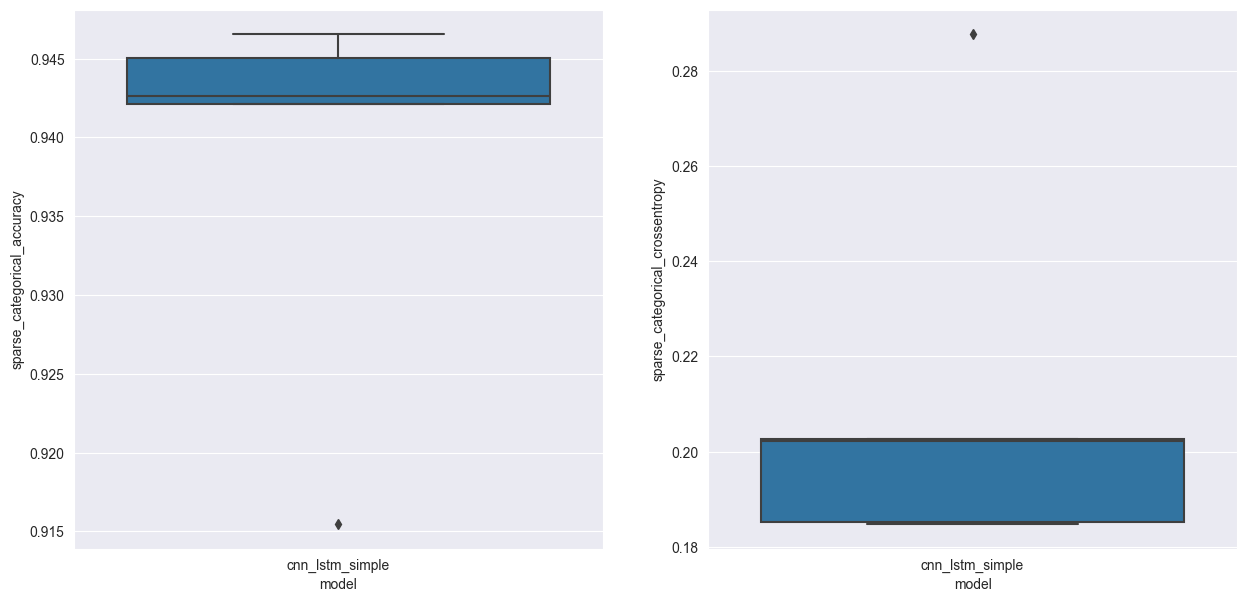

In [3]:
fig, axes = plt.subplots(1, 2, figsize=(15, 7))
sns.boxplot(merged_data, x="model", y="sparse_categorical_accuracy", ax=axes[0])
sns.boxplot(merged_data, x="model", y="sparse_categorical_crossentropy", ax=axes[1])
plt.show()

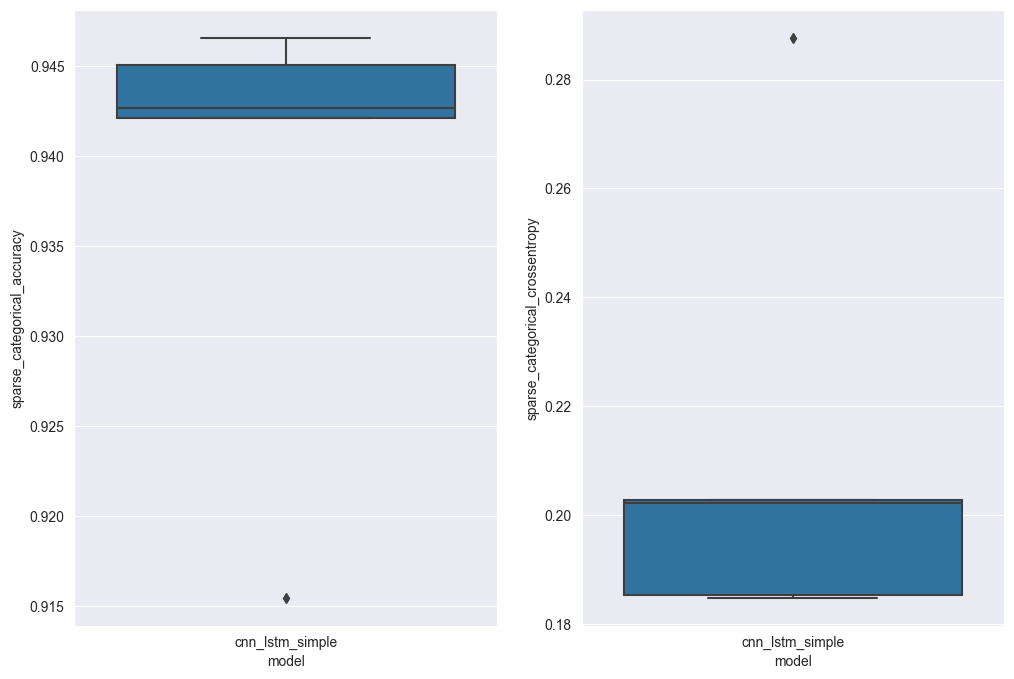

In [4]:
fig, axes = plt.subplots(1, 2, figsize=(12, 8))
sns.boxplot(merged_data.loc[merged_data.model != "cnn_lstm_complex"], x="model", y="sparse_categorical_accuracy",
            ax=axes[0])
sns.boxplot(merged_data.loc[merged_data.model != "cnn_lstm_complex"], x="model", y="sparse_categorical_crossentropy",
            ax=axes[1])
plt.show()

## Confusion Matrix

### Load predicitons

In [5]:
TEST_DATA_PATH = "data/test"

results = []
for root, dirs, files in os.walk(TEST_DATA_PATH):
    if root != "data/test":
        label_name = root.split("\\")[-1]
        results.append(pd.DataFrame({
            "true_labels": [label_name] * len(files),
            "y_true": [class_names.index(label_name)] * len(files),
            "file": files
        }))
    else:
        class_names = dirs

true_labels = pd.concat(results).reset_index(drop=True)
true_labels

,true_labels,y_true,file
0,down,0,down0132a06d_nohash_0.wav
1,down,0,down0132a06d_nohash_4.wav
2,down,0,down0137b3f4_nohash_4.wav
3,down,0,down016e2c6d_nohash_1.wav
4,down,0,down016e2c6d_nohash_2.wav
...,...,...,...
13019,yes,11,yesfce96bac_nohash_0.wav
13020,yes,11,yesfd395b74_nohash_2.wav
13021,yes,11,yesfd395b74_nohash_4.wav
13022,yes,11,yesff21fb59_nohash_0.wav


In [16]:
# files = ["article_net", "cnn_lstm_complex", "cnn_lstm_simple", "stacked_bidirectional_lstm"]
files = ["cnn_lstm_simple"]
def get_predictions(files):
    results = []
    for file in files:
        for pred_file in os.listdir(file):
            if pred_file.startswith("predictions"):
                with open(os.path.join(file, pred_file), "rb") as handle:
                    prediction = pickle.load(handle)
                res = pd.DataFrame({
                    "model": [file] * prediction.shape[0],
                    "pred_file": [pred_file] * prediction.shape[0],
                    "predictions": np.argmax(prediction, axis=1)
                })
                results.append(res)
    return pd.concat(results)
predictions_df = get_predictions(files)
predictions_df

,model,pred_file,predictions
0,cnn_lstm_simple,predictions_0.pkl,0
1,cnn_lstm_simple,predictions_0.pkl,0
2,cnn_lstm_simple,predictions_0.pkl,0
3,cnn_lstm_simple,predictions_0.pkl,0
4,cnn_lstm_simple,predictions_0.pkl,0
...,...,...,...
13019,cnn_lstm_simple,predictions_4.pkl,11
13020,cnn_lstm_simple,predictions_4.pkl,9
13021,cnn_lstm_simple,predictions_4.pkl,9
13022,cnn_lstm_simple,predictions_4.pkl,11


In [7]:
def get_confussion_matrix(model_df):
    pred_files = [f"predictions_{i}.pkl" for i in range(5)]
    class_numbers = len(class_names)
    res_cm = np.zeros((class_numbers, class_numbers))
    for pred_file in pred_files:
        y_pred = model_df.loc[(model_df.pred_file == pred_file), 'predictions']
        cm = confusion_matrix(y_true=true_labels.y_true, y_pred=y_pred)
        res_cm += cm
    res_cm /= len(pred_files)
    return pd.DataFrame(res_cm, index=class_names, columns=class_names)

cm = get_confussion_matrix(predictions_df.loc[predictions_df.model == "cnn_lstm_simple"])
cm

,down,go,left,no,off,on,right,silence,stop,unknown,up,yes
down,403.6,9.4,0.2,12.8,0.4,0.4,0.0,0.0,1.6,42.8,0.4,0.4
go,10.2,386.0,0.6,12.8,1.4,0.6,0.2,0.2,3.6,55.4,2.4,0.6
left,0.2,0.2,424.6,2.2,1.0,0.0,4.0,0.0,0.8,29.6,1.0,7.4
no,5.4,10.6,1.0,422.6,0.8,0.0,0.0,0.0,0.6,31.4,1.0,1.6
off,0.4,0.6,1.4,0.0,405.4,10.8,0.6,0.6,1.6,30.4,19.2,0.0
on,1.0,0.6,0.0,0.2,10.6,404.2,0.0,0.8,0.4,52.6,2.2,0.4
right,0.0,0.0,6.4,0.0,1.2,0.4,416.4,0.0,0.0,48.2,0.2,0.2
silence,0.0,0.0,0.6,0.0,0.0,0.0,0.0,76.2,0.4,2.4,0.4,0.0
stop,2.2,1.4,0.2,0.6,1.8,0.8,0.0,0.0,431.8,31.0,6.0,0.2
unknown,31.2,29.6,14.4,25.0,13.6,30.4,21.8,0.0,16.6,8001.0,16.2,9.2


<Axes: xlabel='Predicted label', ylabel='True label'>

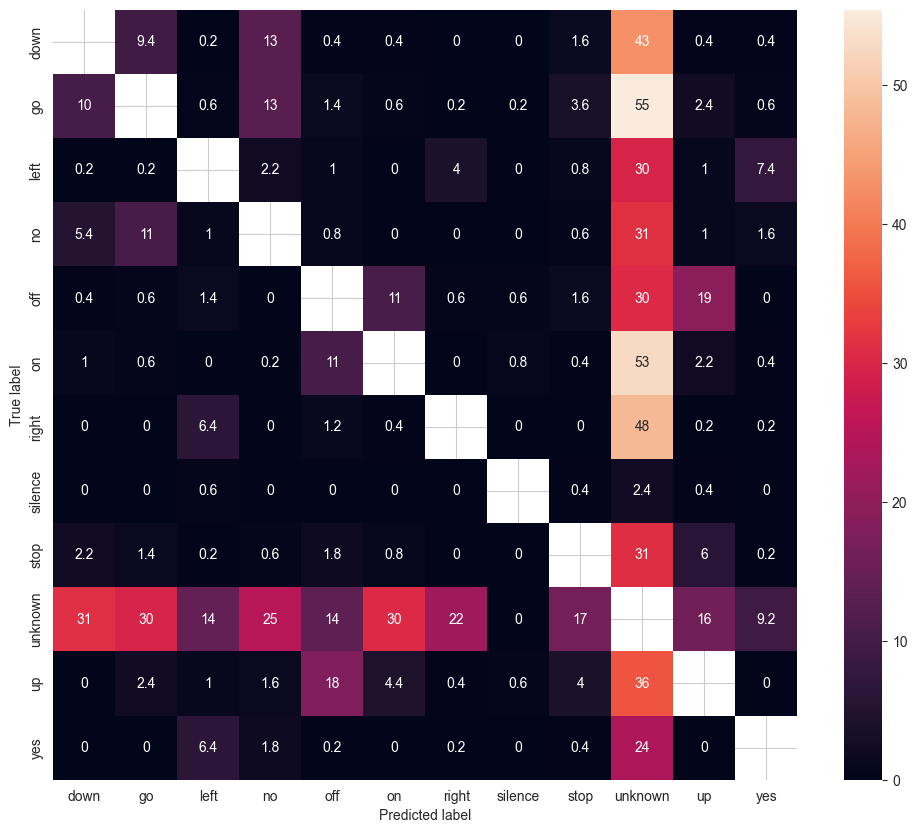

In [49]:
def draw_confusion_matrix(confusion_matrix, diag, ax=None):
    if ax is None:
        fig, ax = plt.subplots(figsize=(12, 10))
    if diag:
        mask = np.diag(v=np.ones(len(class_names))) == 1
        sns.heatmap(data=confusion_matrix, annot=True, mask=mask, ax=ax)
    else:
        sns.heatmap(data=confusion_matrix, annot=True, ax=ax)
    ax.set_xlabel("Predicted label")
    ax.set_ylabel("True label")
    return ax

draw_confusion_matrix(cm, True)

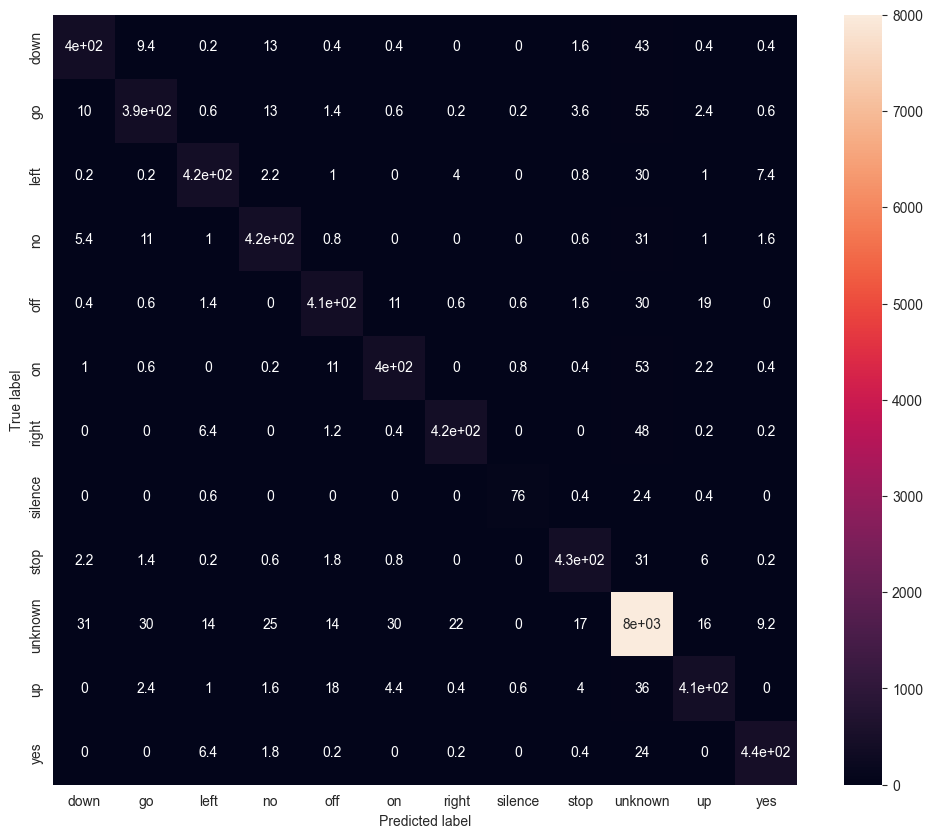

In [9]:
draw_confusion_matrix(cm, False)

## Learning curves

In [21]:
# files = ["article_net", "cnn_lstm_complex", "cnn_lstm_simple", "stacked_bidirectional_lstm"]
files = ["cnn_lstm_simple"]
def get_learning_curves(files):
    results = []
    for file in files:
        for hist_file in os.listdir(file):
            if hist_file.startswith("history"):
                with open(os.path.join(file, hist_file), "rb") as handle:
                    history = pickle.load(handle)
                res = pd.DataFrame(history)
                res["model"] = file
                res["history"] = hist_file
                res = res.reset_index(names="epoch")
                res["epoch"] += 1
                results.append(res)
    return pd.concat(results)

learning_curves = get_learning_curves(files)
learning_curves

,epoch,loss,sparse_categorical_accuracy,sparse_categorical_crossentropy,val_loss,val_sparse_categorical_accuracy,val_sparse_categorical_crossentropy,lr,model,history
0,1,1.469400,0.624841,1.469400,1.328205,0.634884,1.328205,0.010000,cnn_lstm_simple,history_0.pkl
1,2,1.150972,0.663033,1.150972,0.958051,0.696914,0.958051,0.010000,cnn_lstm_simple,history_0.pkl
2,3,0.809909,0.741522,0.809909,0.703551,0.769538,0.703551,0.010000,cnn_lstm_simple,history_0.pkl
3,4,0.638341,0.800662,0.638341,0.627890,0.798250,0.627890,0.010000,cnn_lstm_simple,history_0.pkl
4,5,0.589835,0.814175,0.589835,0.494285,0.845233,0.494285,0.010000,cnn_lstm_simple,history_0.pkl
...,...,...,...,...,...,...,...,...,...,...
31,32,0.057230,0.985719,0.057230,0.160519,0.952403,0.160519,0.001250,cnn_lstm_simple,history_4.pkl
32,33,0.050995,0.988637,0.050995,0.162844,0.952710,0.162844,0.001250,cnn_lstm_simple,history_4.pkl
33,34,0.048400,0.989514,0.048400,0.164475,0.952710,0.164475,0.001250,cnn_lstm_simple,history_4.pkl
34,35,0.045150,0.990480,0.045150,0.162306,0.952403,0.162306,0.000625,cnn_lstm_simple,history_4.pkl


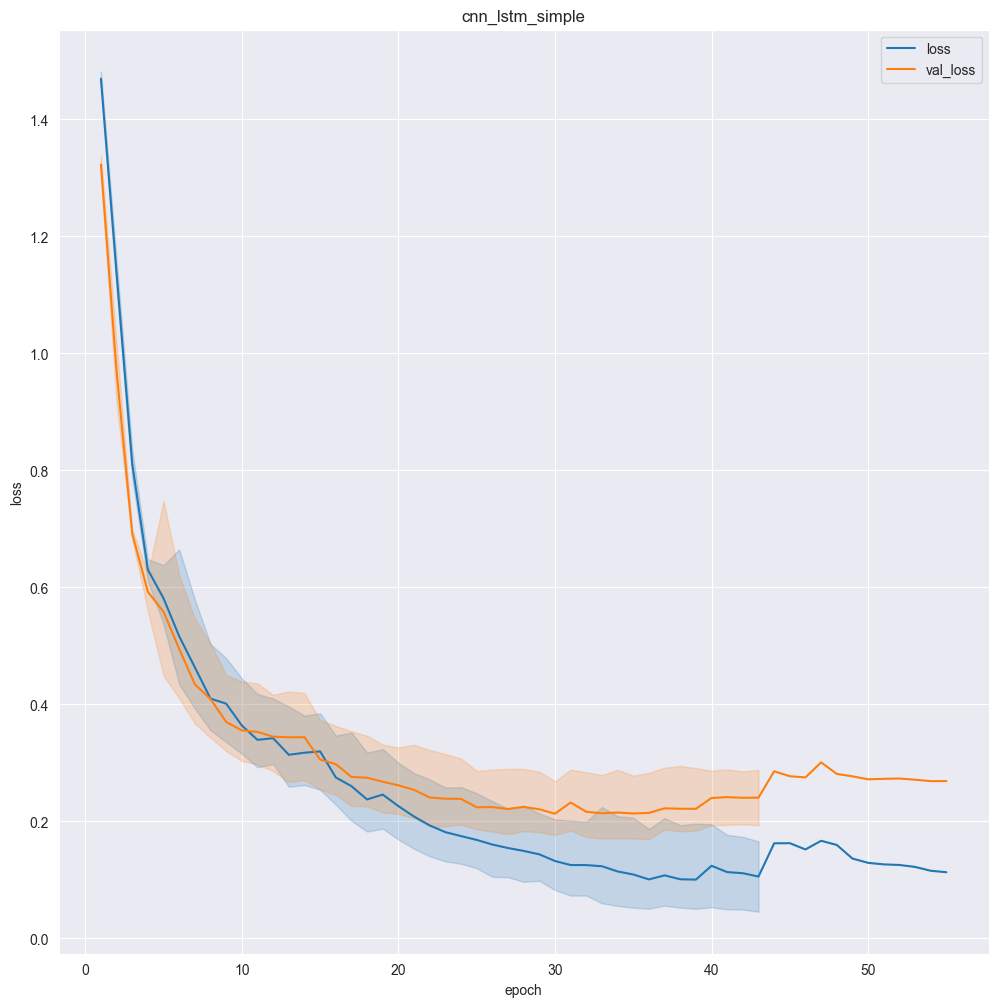

In [22]:
fig, ax = plt.subplots(1, 1, figsize=(12, 12))
# fig, axes = plt.subplots(2, 2, figsize=(12, 12))
for i, file in enumerate(files):
    model_df = learning_curves.loc[learning_curves.model == file]
    # row, col = i // 2, i % 2
    # ax = axes[row][col]
    ax.set_title(file)
    leg = "auto" if i != 0 else False
    sns.lineplot(model_df, x="epoch", y="loss", ax=ax, label="loss")
    sns.lineplot(model_df, x="epoch", y="val_loss", ax=ax, label="val_loss")
plt.show()

# CNN + LSTM

In [44]:
files = ["cnn_lstm_simple", "cnn_lstm_complex"]

merged_data = get_metrics(files)
merged_data

,seed,loss,sparse_categorical_accuracy,sparse_categorical_crossentropy,model
0,0,0.202165,0.942107,0.202165,cnn_lstm_simple
1,1,0.202767,0.942644,0.202767,cnn_lstm_simple
2,2,0.184794,0.945025,0.184794,cnn_lstm_simple
3,3,0.287714,0.915464,0.287714,cnn_lstm_simple
4,4,0.185222,0.946560,0.185222,cnn_lstm_simple
5,0,0.544547,0.828547,0.544547,cnn_lstm_complex
6,1,0.674495,0.798526,0.674495,cnn_lstm_complex
7,2,0.479161,0.855037,0.479161,cnn_lstm_complex
8,3,0.335362,0.900108,0.335362,cnn_lstm_complex
9,4,0.557034,0.823787,0.557034,cnn_lstm_complex


<Axes: xlabel='model', ylabel='sparse_categorical_accuracy'>

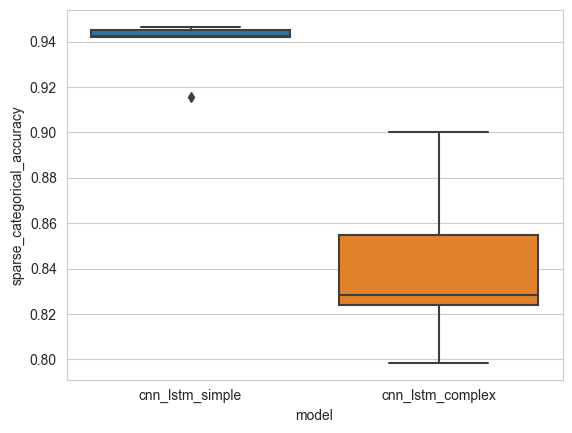

In [32]:
sns.boxplot(merged_data, x="model", y="sparse_categorical_accuracy")

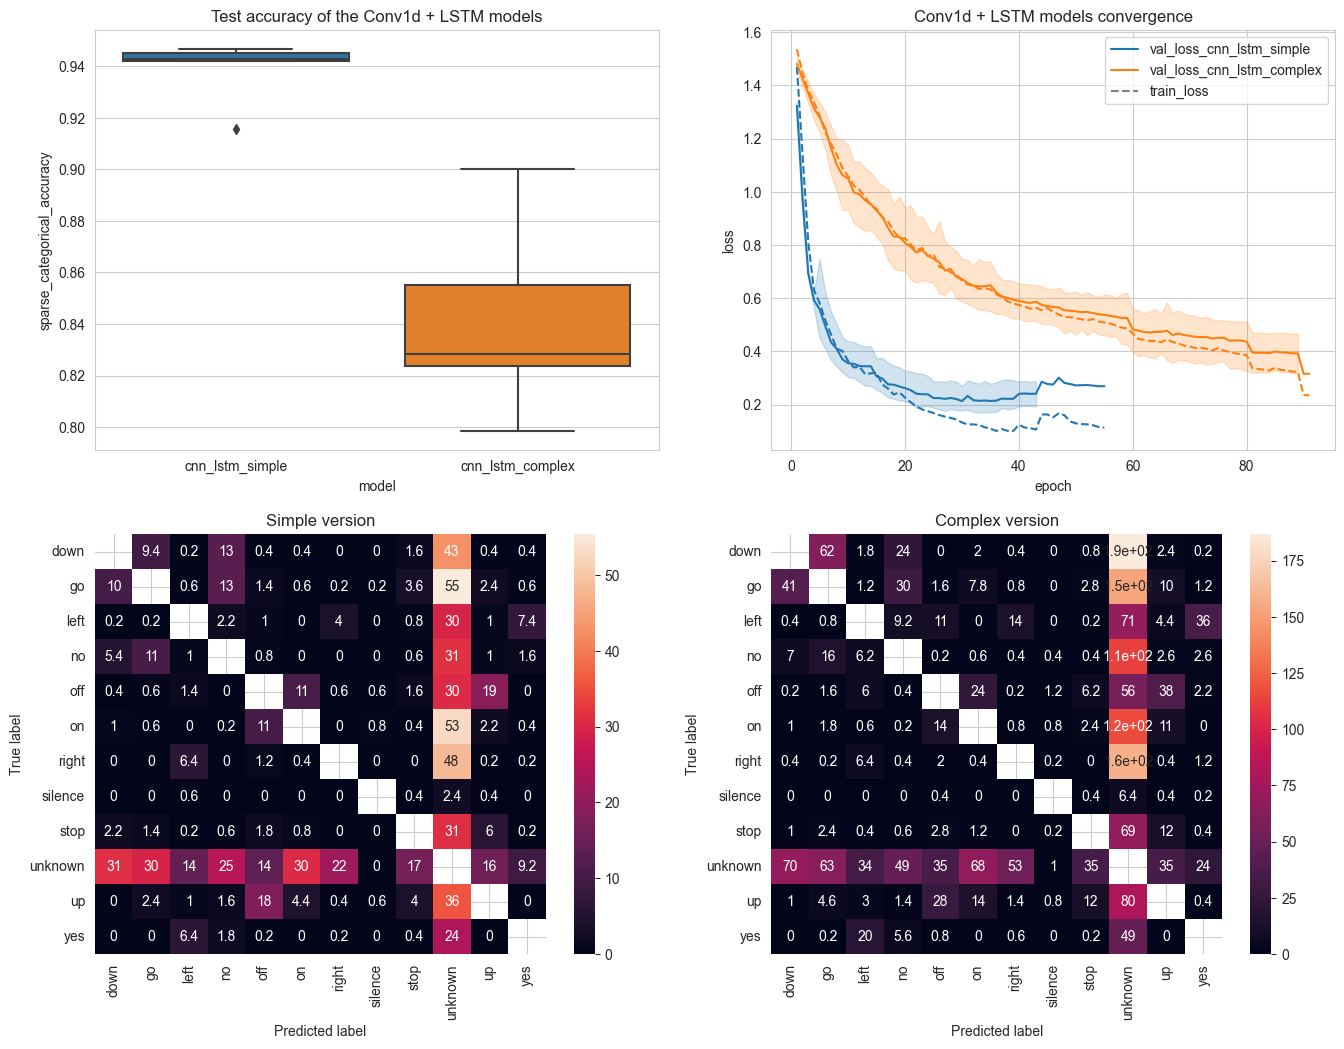

In [71]:
from matplotlib.lines import Line2D

pyplot_colors = ['C' + str(i) for i in range(0, 10)]
learning_curves = get_learning_curves(files)
fig, ax = plt.subplots(2, 2, figsize=(16, 12))
ax[0][1].set_title("Conv1d + LSTM models convergence")
for i, file in enumerate(files):
    model_df = learning_curves.loc[learning_curves.model == file]
    # row, col = i // 2, i % 2
    # ax = axes[row][col]
    color = pyplot_colors[i]
    leg = "auto" if i != 0 else False
    sns.lineplot(model_df, x="epoch", y="loss", ax=ax[0][1], label=None, ls='--', errorbar=None, color=color)
    sns.lineplot(model_df, x="epoch", y="val_loss", ax=ax[0][1], label="val_loss_"+file, color=color)

train_legend_line = Line2D([0], [0], label='train_loss', color='grey', ls='--')
handles, labels = ax[0][1].get_legend_handles_labels()
handles.extend([train_legend_line])
ax[0][1].legend(handles=handles)
sns.boxplot(merged_data, x="model", y="sparse_categorical_accuracy", ax=ax[0][0])
ax[0][0].set_title("Test accuracy of the Conv1d + LSTM models")

predictions = get_predictions(files)
cm_simple = get_confussion_matrix(predictions[predictions.model == 'cnn_lstm_simple'])
cm_complex = get_confussion_matrix(predictions[predictions.model == 'cnn_lstm_complex'])
draw_confusion_matrix(cm_simple, True, ax[1][0])
draw_confusion_matrix(cm_complex, True, ax[1][1])
ax[1][0].set_title("Simple version")
ax[1][1].set_title("Complex version")
plt.show()


# One - vs. bi- directional

In [72]:
files = ["stacked_bidirectional_lstm", "stacked_onedirectional_lstm"]

merged_data = get_metrics(files)
merged_data

,seed,loss,sparse_categorical_accuracy,sparse_categorical_crossentropy,model
0,0,0.174891,0.949094,0.174891,stacked_bidirectional_lstm
1,1,0.181845,0.953087,0.181845,stacked_bidirectional_lstm
2,2,0.212424,0.944487,0.212424,stacked_bidirectional_lstm
3,3,0.169613,0.955390,0.169613,stacked_bidirectional_lstm
4,4,0.231978,0.942568,0.231978,stacked_bidirectional_lstm
5,0,0.198255,0.952933,0.198255,stacked_onedirectional_lstm
6,1,0.250526,0.946944,0.250526,stacked_onedirectional_lstm
7,2,0.183877,0.953547,0.183877,stacked_onedirectional_lstm
8,3,0.195825,0.953317,0.195825,stacked_onedirectional_lstm
9,4,0.211138,0.949862,0.211138,stacked_onedirectional_lstm


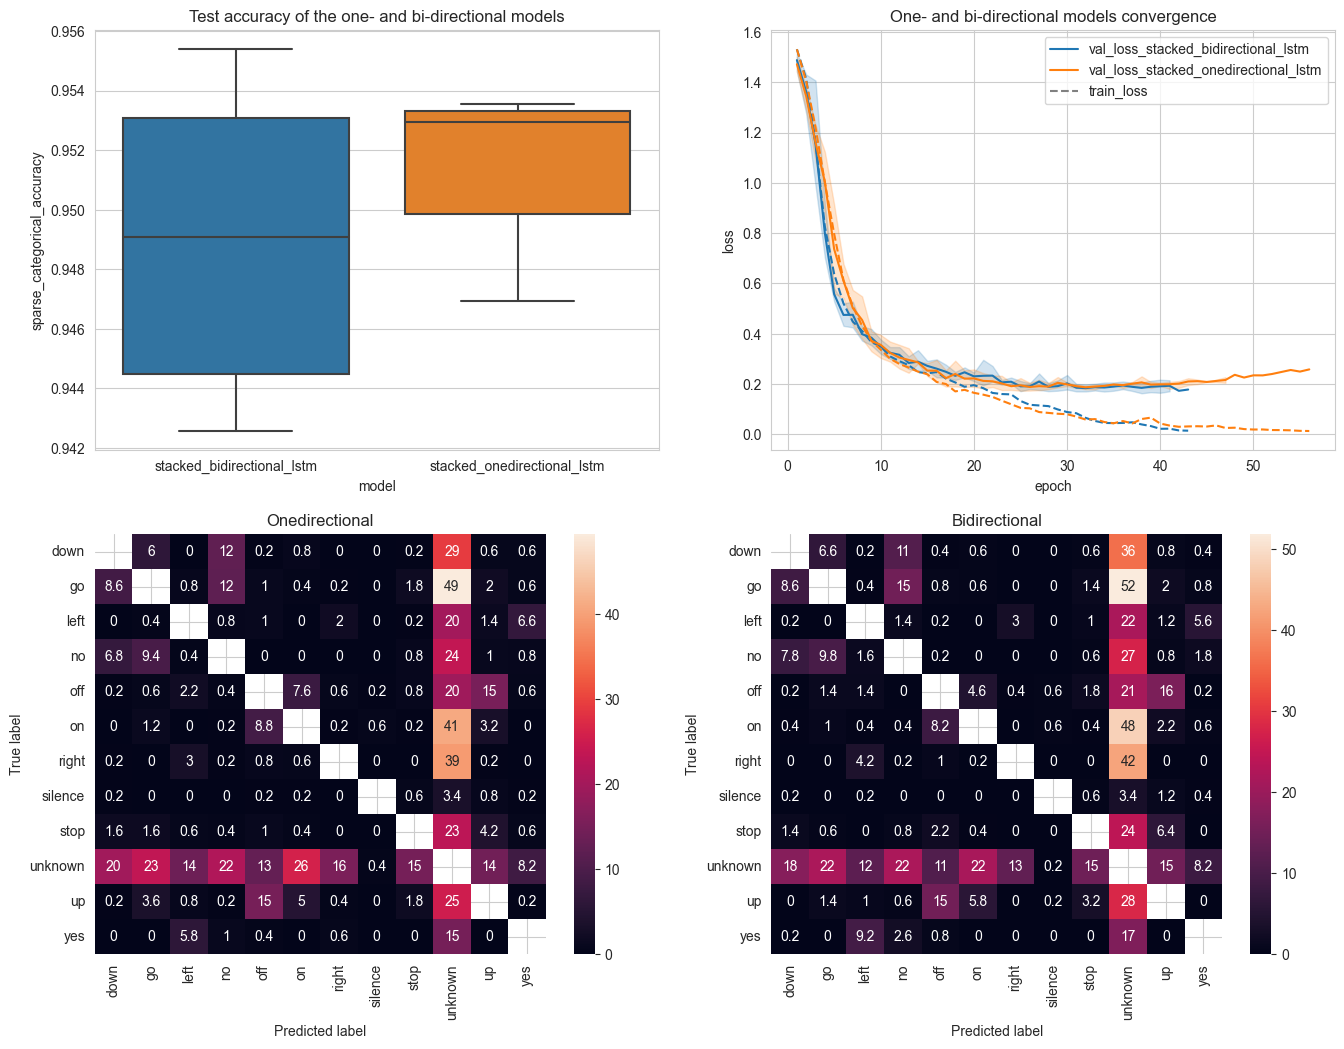

In [73]:
pyplot_colors = ['C' + str(i) for i in range(0, 10)]
learning_curves = get_learning_curves(files)
fig, ax = plt.subplots(2, 2, figsize=(16, 12))
ax[0][1].set_title("One- and bi-directional models convergence")
for i, file in enumerate(files):
    model_df = learning_curves.loc[learning_curves.model == file]
    # row, col = i // 2, i % 2
    # ax = axes[row][col]
    color = pyplot_colors[i]
    leg = "auto" if i != 0 else False
    sns.lineplot(model_df, x="epoch", y="loss", ax=ax[0][1], label=None, ls='--', errorbar=None, color=color)
    sns.lineplot(model_df, x="epoch", y="val_loss", ax=ax[0][1], label="val_loss_"+file, color=color)

train_legend_line = Line2D([0], [0], label='train_loss', color='grey', ls='--')
handles, labels = ax[0][1].get_legend_handles_labels()
handles.extend([train_legend_line])
ax[0][1].legend(handles=handles)
sns.boxplot(merged_data, x="model", y="sparse_categorical_accuracy", ax=ax[0][0])
ax[0][0].set_title("Test accuracy of the one- and bi-directional models")

predictions = get_predictions(files)
cm_2 = get_confussion_matrix(predictions[predictions.model == 'stacked_bidirectional_lstm'])
cm_1 = get_confussion_matrix(predictions[predictions.model == 'stacked_onedirectional_lstm'])
draw_confusion_matrix(cm_1, True, ax[1][0])
draw_confusion_matrix(cm_2, True, ax[1][1])
ax[1][0].set_title("Onedirectional")
ax[1][1].set_title("Bidirectional")
plt.show()
